In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

%load_ext sql

In [2]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [3]:
%sql duckdb:///:default:

# Setup data

In [4]:
%%sql
drop table if exists orders;

,Success


In [5]:
%%sql

create table orders as select * from read_csv_auto(
    './data/retail_orders/orders.csv', 
    names=[
        'customer_id', 
        'status', 
        'order_date', 
        'delivery_date', 
        'order_id', 
        'product_id', 
        'qty', 
        'total', 
        'unit_cost', 
    ],
    skip=1,
    dateformat='%d-%b-%y'
);

,Success


In [6]:
%%sql

update orders set status = lower(status);

,Success


## Moving Averages (self join)

In [7]:
%%sql
with cte as (
select 
    order_date, 
    sum(total) as amt 
from orders group by 1 order by 1 asc)
select 
  a.order_date, 
  a.amt,
  avg(b.amt) as moving_avg
from cte a
join cte b on 
  b.order_date between a.order_date - interval '6' day and a.order_date
group by 1, 2 order by 1 asc
    


,order_date,amt,moving_avg
0,2017-01-01,225.500,225.500000
1,2017-01-02,10476.300,5350.900000
2,2017-01-03,8683.200,6461.666667
3,2017-01-04,3434.190,5704.797500
4,2017-01-05,9129.800,6389.798000
...,...,...,...
1821,2021-12-27,34508.340,26907.890000
1822,2021-12-28,37662.285,27045.540000
1823,2021-12-29,13634.500,25813.540000
1824,2021-12-30,34466.430,26438.295714


<Axes: xlabel='order_date'>

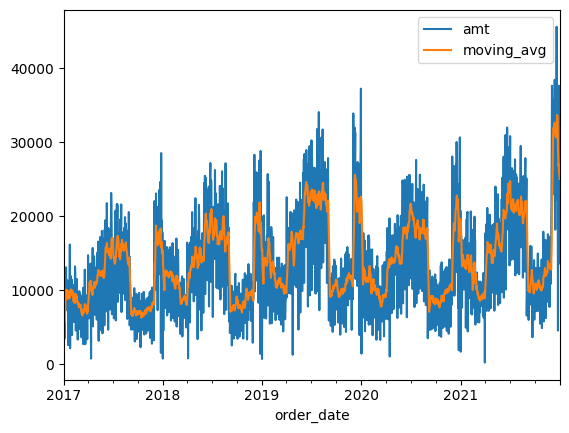

In [8]:
result = _
result.set_index("order_date").plot()

In [ ]:
## Moving Averages (window function)

In [14]:
%%sql
with cte as (
select 
    order_date, 
    sum(total) as amt 
from orders group by 1 order by 1 asc)
select 
  order_date, 
  amt,
  avg(amt)over (order by order_date rows between 3 preceding and 3 following) as moving_avg
from cte 
order by 1 asc
    


,order_date,amt,moving_avg
0,2017-01-01,225.500,5704.797500
1,2017-01-02,10476.300,6389.798000
2,2017-01-03,8683.200,6997.627500
3,2017-01-04,3434.190,7222.720714
4,2017-01-05,9129.800,8942.439286
...,...,...,...
1821,2021-12-27,34508.340,26438.295714
1822,2021-12-28,37662.285,25062.710000
1823,2021-12-29,13634.500,28477.671667
1824,2021-12-30,34466.430,28107.504000


<Axes: xlabel='order_date'>

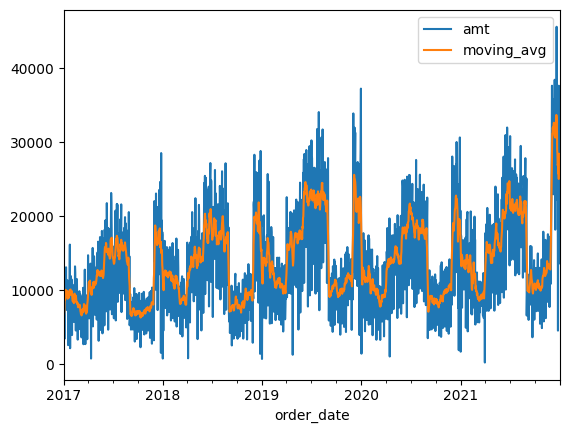

In [15]:
result = _
result.set_index("order_date").plot()

## Cumulative Values (MTD/YTD)

In [16]:
%%sql 
with cte as (
select 
    order_date, 
    sum(total) as amt 
from orders group by 1 order by 1 asc)
select 
  order_date, 
  amt, 
  sum(amt) over (partition by year(order_date), month(order_date) order by order_date) as mtd,
  sum(amt) over (partition by year(order_date) order by order_date) as ytd
from cte
group by 1, 2 order by 1; 

,order_date,amt,mtd,ytd
0,2017-01-01,225.500,225.500,225.500
1,2017-01-02,10476.300,10701.800,10701.800
2,2017-01-03,8683.200,19385.000,19385.000
3,2017-01-04,3434.190,22819.190,22819.190
4,2017-01-05,9129.800,31948.990,31948.990
...,...,...,...,...
1821,2021-12-27,34508.340,824126.955,5830478.475
1822,2021-12-28,37662.285,861789.240,5868140.760
1823,2021-12-29,13634.500,875423.740,5881775.260
1824,2021-12-30,34466.430,909890.170,5916241.690


## Seasonality (MoM/YoY)

In [26]:
%%sql
with cte as (
select 
    order_date - (interval (date_part('day', order_date) - 1) day) as order_date, 
    sum(total) as amt 
from orders group by 1 order by 1 asc)
select 
    order_date,
    amt,
    lag(order_date) over (order by order_date) as prev_month,
    lag(amt) over (order by order_date) as prev_amt
from cte order by order_date;

,order_date,amt,prev_month,prev_amt
0,2017-01-01,286772.775,NaT,NaN
1,2017-02-01,239348.825,2017-01-01,286772.775
2,2017-03-01,224318.975,2017-02-01,239348.825
3,2017-04-01,319435.685,2017-03-01,224318.975
4,2017-05-01,376750.050,2017-04-01,319435.685
5,2017-06-01,473481.000,2017-05-01,376750.050
6,2017-07-01,477803.435,2017-06-01,473481.000
7,2017-08-01,470162.000,2017-07-01,477803.435
8,2017-09-01,210577.320,2017-08-01,470162.000
9,2017-10-01,214402.820,2017-09-01,210577.320


In [43]:
%%sql
with cte as (
select 
    order_date - (interval (date_part('day', order_date) - 1) day) as order_date, 
    sum(total) as amt 
from orders group by 1 order by 1 asc)
select 
    order_date,
    amt,
    lag(amt, 12) ignore nulls over (order by order_date) as prev_amt
from cte order by order_date;

RuntimeError: If using snippets, you may pass the --with argument explicitly.
For more details please refer: https://jupysql.ploomber.io/en/latest/compose.html#with-argument


Original error message from DB driver:
(duckdb.duckdb.ParserException) Parser Error: syntax error at or near "ignore"
LINE 9:     lag(amt, 12) ignore nulls over (order by order_date) as prev_amt
from cte order by order_date;...
                         ^
[SQL: with cte as (
select 
    order_date - (interval (date_part('day', order_date) - 1) day) as order_date, 
    sum(total) as amt 
from orders group by 1 order by 1 asc)
select 
    order_date,
    amt,
    lag(amt, 12) ignore nulls over (order by order_date) as prev_amt
from cte order by order_date;]
(Background on this error at: https://sqlalche.me/e/20/f405)

If you need help solving this issue, send us a message: https://ploomber.io/community


<Axes: xlabel='order_date'>

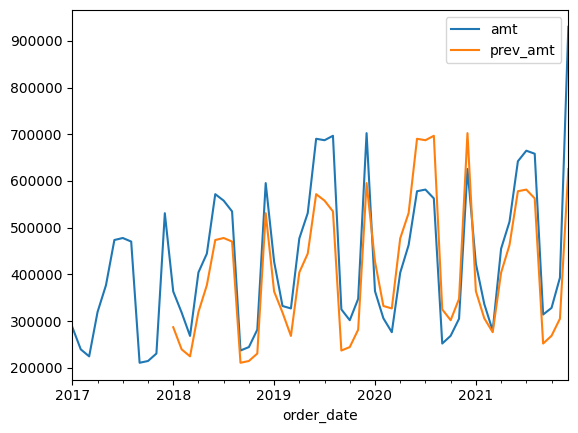

In [28]:
result = _
result.set_index("order_date").plot()

In [32]:
%%sql
select date_part('month',order_date) as month_number
,sum(case when date_part('year',order_date) = 2017 then total end) 
 as sales_2017
,sum(case when date_part('year',order_date) = 2018 then total end) 
 as sales_2018
,sum(case when date_part('year',order_date) = 2019 then total end) 
 as sales_2019
,sum(case when date_part('year',order_date) = 2020 then total end) 
 as sales_2020
,sum(case when date_part('year',order_date) = 2021 then total end) 
 as sales_2021
FROM orders
GROUP BY 1;

,month_number,sales_2017,sales_2018,sales_2019,sales_2020,sales_2021
0,1,286772.775,363311.550,427319.800,363965.360,422961.345
1,2,239348.825,318170.450,332184.675,305807.600,336529.265
2,3,224318.975,268101.805,326955.570,276046.080,279331.885
3,4,319435.685,404202.370,476984.950,403484.095,454806.345
4,5,376750.050,444377.645,531179.400,462698.175,512668.840
5,6,473481.000,571664.945,690287.350,577972.750,642173.510
6,7,477803.435,557841.570,687226.445,581496.045,664787.095
7,8,470162.000,534740.495,696720.975,562614.130,658272.605
8,9,210577.320,236828.905,324951.130,251785.210,313872.490
9,10,214402.820,244206.815,301730.210,268368.005,328082.135


<Axes: xlabel='month_number'>

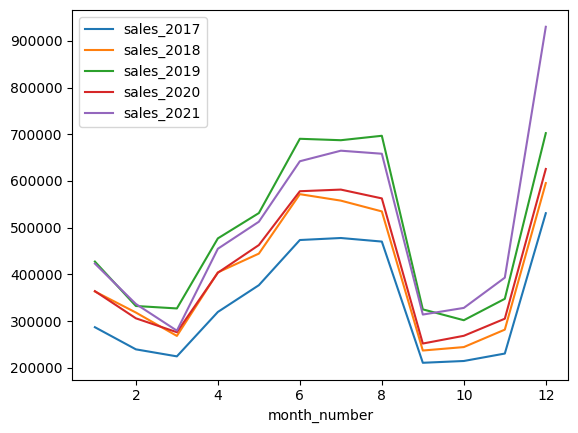

In [33]:
result = _
result.set_index("month_number").plot()

## Comparing to Multiple Prior Periods

In [41]:
%%sql
with cte1 as (
select 
    order_date - (interval (date_part('day', order_date) - 1) day) as sales_month, 
    sum(total) as sales 
from orders group by 1 order by 1),
cte2 as (select sales_month, sales
,lag(sales,1) over (partition by date_part('month',sales_month) 
                    order by sales_month
                    ) as prev_sales_1
,lag(sales,2) over (partition by date_part('month',sales_month) 
                    order by sales_month
                    ) as prev_sales_2
,lag(sales,3) over (partition by date_part('month',sales_month) 
                    order by sales_month
                    ) as prev_sales_3
,lag(sales,4) over (partition by date_part('month',sales_month) 
                    order by sales_month
                    ) as prev_sales_4
FROM cte1)
select * from cte2 where sales_month >= '2021-01-01' order by sales_month asc;

,sales_month,sales,prev_sales_1,prev_sales_2,prev_sales_3,prev_sales_4
0,2021-01-01,422961.345,363965.360,427319.800,363311.550,286772.775
1,2021-02-01,336529.265,305807.600,332184.675,318170.450,239348.825
2,2021-03-01,279331.885,276046.080,326955.570,268101.805,224318.975
3,2021-04-01,454806.345,403484.095,476984.950,404202.370,319435.685
4,2021-05-01,512668.840,462698.175,531179.400,444377.645,376750.050
5,2021-06-01,642173.510,577972.750,690287.350,571664.945,473481.000
6,2021-07-01,664787.095,581496.045,687226.445,557841.570,477803.435
7,2021-08-01,658272.605,562614.130,696720.975,534740.495,470162.000
8,2021-09-01,313872.490,251785.210,324951.130,236828.905,210577.320
9,2021-10-01,328082.135,268368.005,301730.210,244206.815,214402.820


In [42]:
%%sql
with cte1 as (
select 
    order_date - (interval (date_part('day', order_date) - 1) day) as sales_month, 
    sum(total) as sales 
from orders group by 1 order by 1),
cte2 as (
select sales_month, sales
,sales / sum(sales) over (partition by date_part('month',sales_month)
                          order by sales_month
                          rows between 4 preceding and 1 preceding
                          ) as pct_of_prev_4
from cte1)
select * from cte2 where sales_month >= '2021-01-01' order by sales_month asc;

,sales_month,sales,pct_of_prev_4
0,2021-01-01,422961.345,1.173776
1,2021-02-01,336529.265,1.125976
2,2021-03-01,279331.885,1.019997
3,2021-04-01,454806.345,1.134105
4,2021-05-01,512668.840,1.129845
5,2021-06-01,642173.510,1.110352
6,2021-07-01,664787.095,1.153960
7,2021-08-01,658272.605,1.162904
8,2021-09-01,313872.490,1.225894
9,2021-10-01,328082.135,1.275706
